In [1]:
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import pickle
from datetime import datetime
from sklearn.metrics import ConfusionMatrixDisplay
from ipynb.fs.defs.Prepare_Data import train_test_val
from ipynb.fs.defs.Prepare_Data import load_csv_into_df
from ipynb.fs.defs.Prepare_Data import combine_dataframes
from ipynb.fs.defs.Feature_Engineering import preprocess_dataset
from ipynb.fs.defs.Data_Augmentation import data_augmentation

In [46]:
def store_predictions(model, X_test, y_test, y_pred, features, timestamp):
    vectorizer_path = f"../models/vectorizer_{timestamp}.pkl"
    # Load the vectorizer from the file
    with open(vectorizer_path, 'rb') as f:
        vectorizer = pickle.load(f)

    vocabulary_path = f"../models/vocabulary_{timestamp}.pkl" 
    # Get the vocabulary of the training data
    with open(vocabulary_path, 'rb') as f:
        vocabulary = pickle.load(f)
        
    
    probabilities = model.predict_proba(X_test)

    # Extrahieren der wichtigsten Features
    boost = model.booster_
    importance = boost.feature_importance()
    feature_names = boost.feature_name()
    sorted_idx = np.argsort(importance)[::-1]

    feature_dict = {vocabulary.shape[0]+index: key for index, key in enumerate(features)}

    true_label = y_test.reset_index(drop=True)

    X_test_restored = vectorizer.inverse_transform(X_test[:,:vocabulary.shape[0]-len(features)])
    original_designation = [' '.join(words) for words in X_test_restored]

    # Ausgabe der Vorhersagen, der Wahrscheinlichkeiten und der wichtigsten Features
    for i in range(len(X_test)):
        print('Vorhersage für Sample {}: {}'.format(i+1, y_pred[i]), 'True: {}'.format(true_label[i]))
        print(original_designation[i])

        print('Wahrscheinlichkeit für Sample {}: {}'.format(i+1, probabilities[i][1]))
        if y_pred[i] == 0 and true_label[i] == 1:
            print('Wichtigste Features für Sample {}:'.format(i+1))
            for j in sorted_idx:
                if importance[j] > 0:
                    if j < vocabulary.shape[0]:
                        print('{} ({}) Value: {}'.format(feature_names[j], importance[j], vocabulary[j]))
                    else:
                        print('{} ({}) Value: {}'.format(feature_names[j], importance[j], feature_dict[j]))
                else:
                    continue
        print('------------------------')

In [47]:
# Loading and preprocessing the data
#df = pd.read_excel('../data/labeled_data/G65_labeled.xlsx',index_col=0)
folder_path = "../data/labeled_data"
dataframes_list = load_csv_into_df(folder_path, original_prisma_data=False, move_to_archive=False)
df_combined = combine_dataframes(dataframes_list)
df_preprocessed, df_for_plot = preprocess_dataset(df_combined, cut_percent_of_front=0.25)

2023-05-12 16:41:42.410 | INFO     | ipynb.fs.defs.Prepare_Data:load_csv_into_df:34 - Loading the data...
2023-05-12 16:41:47.333 | SUCCESS  | ipynb.fs.defs.Prepare_Data:load_csv_into_df:68 - 4 dataframe(s) were created.
2023-05-12 16:42:01.263 | SUCCESS  | ipynb.fs.defs.Prepare_Data:combine_dataframes:91 - 4 dataframe(s) are combined to one dataset and stored in a excel file.
2023-05-12 16:42:01.266 | INFO     | ipynb.fs.defs.Feature_Engineering:preprocess_dataset:199 - Start preprocessing the dataframe with 15849 samples...
2023-05-12 16:42:11.250 | SUCCESS  | ipynb.fs.defs.Feature_Engineering:preprocess_dataset:255 - The dataset is successfully preprocessed. The new dataset contains 2625 samples


In [48]:
# Declare which data augmentation techniques should be used
rand_order = True
rand_mistakes = True
gpt = True

# Generate the new dataset
df_aug = data_augmentation(df_preprocessed, rand_order, rand_mistakes, gpt, df_to_excel = False)

2023-05-12 16:42:11.293 | INFO     | ipynb.fs.defs.Data_Augmentation:data_augmentation:194 - Start adding artificial designations...
2023-05-12 16:43:06.153 | SUCCESS  | ipynb.fs.defs.Data_Augmentation:data_augmentation:237 - Creating a new dataset with artificial designations was succeccfull!


In [49]:
dateTimeObj = datetime.now()
timestamp = dateTimeObj.strftime("%d%m%Y_%H%M")

In [50]:
# Split dataset
X_train, y_train, X_val, y_val, X_test, y_test, features = train_test_val(df_aug, test_size=0.4, timestamp=timestamp)


c:\Users\q617269\AppData\Local\anaconda3\envs\envMesstool\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


c:\Users\q617269\AppData\Local\anaconda3\envs\envMesstool\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[5]	training's auc: 0.988011	training's binary_logloss: 0.547882	valid_1's auc: 0.969401	valid_1's binary_logloss: 0.55698


 Test accuracy: 0.9028925619834711
Vorhersage für Sample 1: 0 True: 0
mitte motorraum si stirnwand
Wahrscheinlichkeit für Sample 1: 0.43237559508874845
------------------------
Vorhersage für Sample 2: 0 True: 0
2 halteleiste li vas
Wahrscheinlichkeit für Sample 2: 0.3891920168533572
------------------------
Vorhersage für Sample 3: 0 True: 0
gpr si uerss
Wahrscheinlichkeit für Sample 3: 0.41235126849492426
------------------------
Vorhersage für Sample 4: 0 True: 0
laengstraeger li schliessblech
Wahrscheinlichkeit für Sample 4: 0.38929073914561146
------------------------
Vorhersage für Sample 5: 0 True: 0
betaetigung li md mit rueckllfe schloss


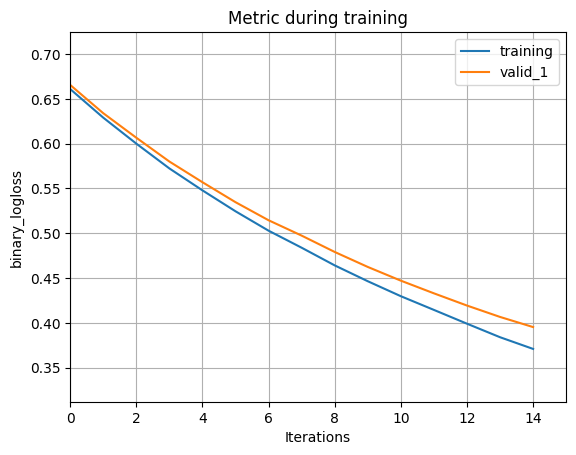

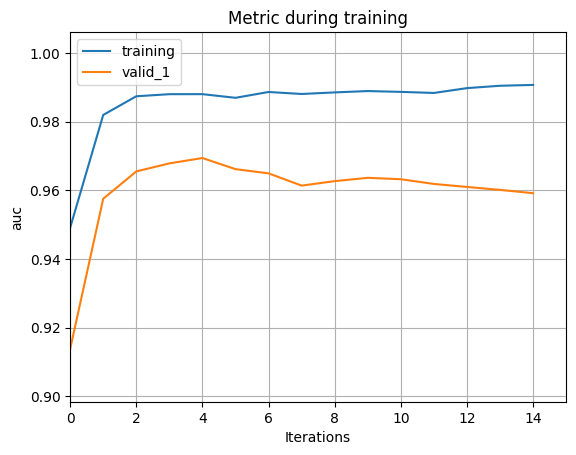

In [51]:
store_preds = True
weight_factor = round(df_aug[df_aug["Relevant fuer Messung"]=="Nein"].shape[0] / df_aug[df_aug["Relevant fuer Messung"]=="Ja"].shape[0])
#weight_factor=7
class_weight = {0: 1, 1: weight_factor}

lgbm_train = lgb.Dataset(X_train, y_train, weight=y_train.map(class_weight))
lgbm_eval = lgb.Dataset(X_val, y_val, reference=lgbm_train)

evals = {}
callbacks = [lgb.early_stopping(10), lgb.record_evaluation(evals)]

gbm = LGBMClassifier(objective='binary',
                      metric=['auc', 'binary_logloss'],
                      num_leaves=31,
                      learning_rate=0.05,
                      feature_fraction=0.9,
                      n_estimators=500,
                      class_weight=class_weight)

gbm.fit(X_train, y_train,
         eval_set=[(X_train, y_train), (X_val, y_val)], 
         eval_metric=['auc', 'binary_logloss'],
         early_stopping_rounds=20,
         callbacks=callbacks)

# save model
model_path = f"../models/lgbm_{timestamp}.pkl"
with open(model_path, "wb") as filestore:
    pickle.dump(gbm, filestore)

#y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration, force_row_wise=True)
y_pred = gbm.predict(X_test)
y_pred = np.round(y_pred)

# Print accuracy score
accuracy = accuracy_score(y_test, y_pred)
print("\n\n Test accuracy:", accuracy)

lgb.plot_metric(evals, metric='binary_logloss')
lgb.plot_metric(evals, metric='auc')

if store_preds:
    store_predictions(gbm, X_test, y_test, y_pred, features, timestamp)


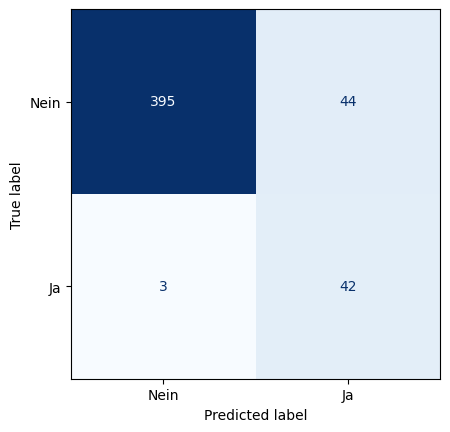

In [52]:
class_names = ["Nein", "Ja"]
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=class_names, cmap='Blues', colorbar=False)
